# Model training

## XGBoost

In [1]:
import pandas as pd, numpy as np
from typing import Iterator, Tuple
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

### Carga de datos

In [2]:
# Obtener .parquet de datos muestreados
SAMPLE_PATH = 'D:/2025/UVG/Tesis/repos/backend/features_sampled_without_idle_rows/sample_features.parquet'

data = pd.read_parquet(SAMPLE_PATH)

# Renombrar columna "Altitud (m)" a "Altitud"
data = data.rename(columns={"Altitud (m)": "Altitud"})

data.head()

,Placa,trip_id,block_id,LINEA,DIR,proxima_est_teorica,Fecha,dist_a_prox_m,dist_estacion_m,vel_mps,...,dist_m,time_diff,dwell_same_xy_s,is_no_progress,progress_event,hour,dow,is_weekend,is_peak,ETA_proxima_est_s
0,49,1,1,Linea_12,IDA,MONTE MARÍA,2024-01-12 09:38:23,2507.478516,361.775177,0.0,...,320.33194,60.0,0.0,0,0,9,4,0,1,657.0
1,49,1,1,Linea_12,IDA,MONTE MARÍA,2024-01-12 09:39:23,2507.478516,361.775177,0.0,...,320.33194,60.0,60.0,1,0,9,4,0,1,597.0
2,49,1,1,Linea_12,IDA,MONTE MARÍA,2024-01-12 09:40:23,2507.478516,361.775177,0.0,...,320.33194,60.0,120.0,1,0,9,4,0,1,537.0
3,49,1,1,Linea_12,IDA,MONTE MARÍA,2024-01-12 09:41:23,2507.478516,361.775177,0.0,...,320.33194,60.0,180.0,1,0,9,4,0,1,477.0
4,49,1,1,Linea_12,IDA,MONTE MARÍA,2024-01-12 09:42:23,2507.478516,361.775177,0.0,...,320.33194,60.0,240.0,1,0,9,4,0,1,417.0


In [3]:
# Preparar datos

# Columnas iniciales
str_cols = ["Placa","trip_id","block_id","LINEA","DIR","proxima_est_teorica"]
dt_cols  = ["Fecha"]
float_cols = [
    "dist_a_prox_m","dist_estacion_m","vel_mps","Altitud","s_m","dist_m",
    "time_diff","dwell_same_xy_s","ETA_proxima_est_s"
]
int_cols = ["hour","dow"]
boolish_cols = ["is_no_progress","progress_event","is_weekend","is_peak"]

# Convertir tipos
for c in str_cols: # Convertir a string de Python no a StringDtype de pandas
    data[c] = data[c].astype("category").cat.rename_categories(lambda x: str(x))
for c in dt_cols:
    data[c] = pd.to_datetime(data[c])
for c in float_cols:
    data[c] = data[c].astype("float32")
for c in int_cols:
    data[c] = data[c].astype("int32")
for c in boolish_cols:
    data[c] = data[c].astype("bool")

In [6]:
data.dtypes

Placa                        category
trip_id                      category
block_id                     category
LINEA                        category
DIR                          category
proxima_est_teorica          category
Fecha                  datetime64[ns]
dist_a_prox_m                 float32
dist_estacion_m               float32
vel_mps                       float32
Altitud                       float32
s_m                           float32
dist_m                        float32
time_diff                     float32
dwell_same_xy_s               float32
is_no_progress                   bool
progress_event                   bool
hour                            int32
dow                             int32
is_weekend                       bool
is_peak                          bool
ETA_proxima_est_s             float32
dtype: object

### Train / valid / test split

In [4]:
df = data.copy()
dev_df = df[df["Fecha"] < "2025-04-01"]   # TODO lo anterior a abril 2025
test_df = df[df["Fecha"] >= "2025-04-01"] # TODO abril 2025 en adelante

In [19]:
def day_based_time_cv_full(
    df: pd.DataFrame,
    day_col: str = "Fecha",
    min_train_days: int = 30,   # entrena al menos 30 días antes del 1er fold
    valid_days: int = 2,        # ventana de validación por fold
    step_days: int = 7,         # cuánto avanzas la ventana por fold (stride)
    embargo_days: int = 0,      # buffer entre train y valid (opcional)
    max_splits = None,  # None = hasta agotar el timeline
) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
    d = df.copy()
    d["__day__"] = pd.to_datetime(d[day_col]).dt.normalize()
    unique_days = np.array(sorted(d["__day__"].unique()))
    total_days = len(unique_days)

    start_valid = min_train_days + embargo_days
    splits = 0
    while start_valid + valid_days <= total_days:
        train_last = start_valid - embargo_days - 1
        valid_start = start_valid
        valid_end   = start_valid + valid_days  # exclusivo

        train_days = set(unique_days[:train_last+1])
        valid_days_set = set(unique_days[valid_start:valid_end])

        mask_train = d["__day__"].isin(train_days).values
        mask_valid = d["__day__"].isin(valid_days_set).values

        tr_idx = df.index[mask_train].values
        va_idx = df.index[mask_valid].values

        yield np.sort(tr_idx), np.sort(va_idx)

        splits += 1
        if (max_splits is not None) and (splits >= max_splits):
            break
        start_valid += step_days  # avanza la ventana

In [20]:
def summarize_splits(df, splits, day_col="Fecha", key_cols=("Placa","trip_id")):
    df = df.copy()
    df["__day__"] = pd.to_datetime(df[day_col]).dt.normalize()
    df["__trip_key__"] = list(zip(*[df[c].astype(str) for c in key_cols]))  # (Placa, trip_id)

    for i, (tr_idx, va_idx) in enumerate(splits, 1):
        tr_days = df.loc[tr_idx, "__day__"].unique()
        va_days = df.loc[va_idx, "__day__"].unique()

        print(f"\nFold {i}")
        print("  Train days:", tr_days.min(), "→", tr_days.max(), f"({len(tr_days)} días, {len(tr_idx):,} filas)")
        print("  Valid days:", va_days.min(), "→", va_days.max(), f"({len(va_days)} días, {len(va_idx):,} filas)")
        day_overlap = set(tr_days) & set(va_days)
        print("  Day overlap? ", "YES" if day_overlap else "NO")

        tr_keys = set(df.loc[tr_idx, "__trip_key__"].unique())
        va_keys = set(df.loc[va_idx, "__trip_key__"].unique())
        key_overlap = tr_keys & va_keys
        print("  Trip overlap (Placa,trip_id)? ", f"YES ({len(key_overlap)})" if key_overlap else "NO")


In [21]:
splits = list(day_based_time_cv_full(
    dev_df,
    day_col="Fecha",
    min_train_days=30,
    valid_days=5,
    step_days=30,        # un fold por dos meses
    embargo_days=0,     # buffer de 0 días
    max_splits=None     # None = hasta el final del timeline
))


# Verificar los splits
summarize_splits(dev_df, splits)


Fold 1
  Train days: 2024-01-01 00:00:00 → 2024-01-30 00:00:00 (30 días, 332,231 filas)
  Valid days: 2024-01-31 00:00:00 → 2024-02-04 00:00:00 (5 días, 67,868 filas)
  Day overlap?  NO
  Trip overlap (Placa,trip_id)?  NO

Fold 2
  Train days: 2024-01-01 00:00:00 → 2024-02-29 00:00:00 (60 días, 691,367 filas)
  Valid days: 2024-03-01 00:00:00 → 2024-03-05 00:00:00 (5 días, 55,245 filas)
  Day overlap?  NO
  Trip overlap (Placa,trip_id)?  NO

Fold 3
  Train days: 2024-01-01 00:00:00 → 2024-03-30 00:00:00 (90 días, 980,057 filas)
  Valid days: 2024-03-31 00:00:00 → 2024-04-04 00:00:00 (5 días, 56,996 filas)
  Day overlap?  NO
  Trip overlap (Placa,trip_id)?  NO

Fold 4
  Train days: 2024-01-01 00:00:00 → 2024-04-29 00:00:00 (120 días, 1,302,882 filas)
  Valid days: 2024-04-30 00:00:00 → 2024-05-04 00:00:00 (5 días, 54,200 filas)
  Day overlap?  NO
  Trip overlap (Placa,trip_id)?  NO

Fold 5
  Train days: 2024-01-01 00:00:00 → 2024-05-29 00:00:00 (150 días, 1,648,828 filas)
  Valid days:

### Entrenamiento

In [5]:
# Definir características y objetivo

categorical_features = ["LINEA","DIR","proxima_est_teorica"]
numeric_features = [
    "dist_a_prox_m","dist_estacion_m",
    "vel_mps","Altitud","s_m","dist_m",
    "time_diff","dwell_same_xy_s","hour","dow",
    "is_no_progress","progress_event","is_weekend","is_peak"
]

feature_cols = categorical_features + numeric_features
target_col = "ETA_proxima_est_s"

In [6]:
SEED = 25

In [9]:
# Para métricas

SLA_THRESH = [60, 120, 180]    # segundos

def compute_metrics(y_true, y_pred, sla_thresh=SLA_THRESH):
    mae  = float(mean_absolute_error(y_true, y_pred))
    rmse = float(root_mean_squared_error(y_true, y_pred))
    abs_err = np.abs(y_pred - y_true)
    sla = {f"sla_le_{t}s": float((abs_err <= t).mean()) for t in sla_thresh}
    return {"mae": mae, "rmse": rmse, **sla}


# Definir parámetros
params = {
    "objective": "reg:squarederror",
    "eval_metric": ["mae", "rmse"],
    "learning_rate": 0.05,
    "max_depth": 6,            # ≈ num_leaves 64 (aprox capacidad)
    "min_child_weight": 200,   # ~ min_data_in_leaf
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "tree_method": "hist",
    "max_bin": 255,
    "random_state": SEED,
}

Validación cruzada

In [77]:
fold_results, models, best_iters, fi_gain_list = [], [], [], []

for fold, (tr_idx, va_idx) in enumerate(splits, 1):
    print(f"\n=== Fold {fold} ===")

    X_tr = dev_df.loc[tr_idx, feature_cols].copy()
    y_tr = dev_df.loc[tr_idx, target_col].values
    X_va = dev_df.loc[va_idx, feature_cols].copy()
    y_va = dev_df.loc[va_idx, target_col].values

    # Asegurarse que las categorías sean Python str (evitar pandas StringDtype 'string[python]')
    # XGBoost falla si las categorías internas usan el tipo StringDtype; convertir las categorías a str.
    """ for df_ in (X_tr, X_va):
        for col in categorical_features:
            if pd.api.types.is_categorical_dtype(df_[col]):
                df_[col] = df_[col].cat.rename_categories(lambda x: str(x)) """

    # DMatrix detecta categóricas si dtype='category' y enable_categorical=True en params
    dtrain = xgb.DMatrix(X_tr, label=y_tr, enable_categorical=True)
    dvalid = xgb.DMatrix(X_va, label=y_va, enable_categorical=True)

    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=3000,
        evals=[(dvalid, f"valid{fold}")],
        early_stopping_rounds=300,
        verbose_eval=False,
    )

    # Predicción usando la mejor iteración
    best_iter = getattr(booster, "best_iteration", None)
    if best_iter is None:
        # fallback para versiones antiguas
        y_pred = booster.predict(dvalid, ntree_limit=booster.best_ntree_limit)
        best_iter = booster.best_ntree_limit
    else:
        y_pred = booster.predict(dvalid, iteration_range=(0, best_iter + 1))

    metrics = compute_metrics(y_va, y_pred, SLA_THRESH)
    metrics["fold"] = fold
    metrics["best_iter"] = int(best_iter)
    fold_results.append(metrics)
    best_iters.append(best_iter)
    models.append(booster)

    # Importancias por gain
    score = booster.get_score(importance_type="gain")  # dict {feat: gain}
    fi_gain = pd.DataFrame({"feature": list(score.keys()), "gain": list(score.values()), "fold": fold})
    fi_gain_list.append(fi_gain)


=== Fold 1 ===

=== Fold 2 ===

=== Fold 3 ===

=== Fold 4 ===

=== Fold 5 ===

=== Fold 6 ===

=== Fold 7 ===

=== Fold 8 ===

=== Fold 9 ===

=== Fold 10 ===

=== Fold 11 ===

=== Fold 12 ===

=== Fold 13 ===

=== Fold 14 ===

=== Fold 15 ===


In [78]:
cv_df = pd.DataFrame(fold_results).set_index("fold")
print("\n=== Métricas por fold (XGB) ===")
print(cv_df)
print("\n=== Promedio CV ± std (XGB) ===")
print(cv_df.agg(["mean","std"]))

avg_best_iter = int(np.mean([int(b) for b in best_iters]))
print(f"\nIteraciones promedio (best_iteration): {avg_best_iter}")

fi_gain_all = pd.concat(fi_gain_list, ignore_index=True)
fi_gain_mean = fi_gain_all.groupby("feature")["gain"].mean().sort_values(ascending=False)
print("\nTop-20 features por gain promedio (XGB):")
print(fi_gain_mean.head(20))


=== Métricas por fold (XGB) ===
             mae        rmse  sla_le_60s  sla_le_120s  sla_le_180s  best_iter
fold                                                                         
1     125.265472  304.213318    0.577828     0.756822     0.833441        877
2     107.251045  272.445496    0.615893     0.790859     0.861472        661
3     119.949364  369.786102    0.637782     0.797705     0.862096       2999
4     106.672066  285.865723    0.622435     0.792878     0.865351       2981
5     105.032524  273.298615    0.630680     0.796127     0.866540       2993
6     110.525406  301.220428    0.605015     0.781027     0.859036       2557
7     139.488663  354.943512    0.580608     0.746300     0.820954       2978
8     113.440384  292.463959    0.607543     0.780844     0.854932        993
9     129.641495  328.168854    0.594461     0.762322     0.836291        757
10    127.874504  334.459534    0.593692     0.758696     0.836875        899
11    130.427658  320.965424   

In [ ]:
import os, json, datetime, platform

model_dir = "D:/2025/UVG/Tesis/repos/backend/models/xgboost/cross_validation_models"
os.makedirs(model_dir, exist_ok=True)

# 1) Guardar boosters por fold en JSON + config
for fold, booster in enumerate(models, 1):
    booster.save_model(f"{model_dir}/xgb_model_fold{fold}.json")
    # Booster.save_config() returns a JSON string (no args), so write it to file explicitly.
    cfg = booster.save_config()
    with open(f"{model_dir}/xgb_model_fold{fold}.config.json", "w", encoding="utf-8") as f:
        f.write(cfg)

# 2) Guardar métricas y FI
cv_df.to_csv(f"{model_dir}/cv_metrics.csv")
fi_gain_all.to_csv(f"{model_dir}/cv_feature_importances_gain.csv", index=False)

# 3) Guardar parámetros usados y metadatos
meta = {
    "params": params,
    "xgboost_version": xgb.__version__,
    "created_at": datetime.datetime.now().isoformat(),
    "python_version": platform.python_version(),
    "feature_cols": list(feature_cols),
    "target_col": target_col,
    "splits_summary": {
        "n_folds": len(models),
        "notes": "Time-based CV (day blocks), same splits as LGBM baseline"
    },
    "best_iters": list(map(int, best_iters)),
    "recommend_final_rounds": int(np.median(best_iters))  # o int(np.mean(...)*1.05)
}
with open(f"{model_dir}/manifest.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

# 4) Guardar esquema de dtypes (para reproducir preprocessing en inferencia)
dtypes_info = {c: str(dev_df[c].dtype) for c in feature_cols + [target_col]}
pd.Series(dtypes_info).to_csv(f"{model_dir}/feature_dtypes.csv", header=False)

# 5) Guardar categorías por columna
CATEGORICAL_COLS = ["Placa","trip_id","block_id","LINEA","DIR","proxima_est_teorica"]
cat_maps = {c: list(dev_df[c].astype("category").cat.categories) for c in CATEGORICAL_COLS if c in dev_df.columns}
with open(f"{model_dir}/categorical_mappings.json","w", encoding="utf-8") as f:
    json.dump(cat_maps, f, indent=2)

Modelo final

In [7]:
# Obtener el archivo guardado de cv metrics
import pandas as pd
cv_metrics = pd.read_csv("D:/2025/UVG/Tesis/repos/backend/models/xgboost/cross_validation_models/cv_metrics.csv", index_col="fold")
best_iters = cv_metrics["best_iter"]

# Calcular la mediana de best_iters para usar en el modelo final
final_rounds = int(np.median(best_iters))
print(f"Usando {final_rounds} iteraciones para el modelo final.")

Usando 1604 iteraciones para el modelo final.


In [10]:
final_rounds = int(np.median(best_iters))

# 2) Split temporal interno (10% final)
df_all = dev_df.copy()
cutoff = df_all['Fecha'].quantile(0.90)

# Viajes “tardíos” = viajes cuyo último timestamp cae en el 10% final
trip_last = df_all.groupby("trip_id", observed=False)["Fecha"].max()
late_trip_ids = set(trip_last[trip_last >= cutoff].index)

valid_df = df_all[df_all["trip_id"].isin(late_trip_ids)].copy()
train_df = df_all[~df_all["trip_id"].isin(late_trip_ids)].copy()

dtrain = xgb.DMatrix(
    train_df[feature_cols],
    label=train_df[target_col].values,
    enable_categorical=True
)

dvalid = xgb.DMatrix(
    valid_df[feature_cols],
    label=valid_df[target_col].values,
    enable_categorical=True
)

print('Comenzando entrenamiento final...')

evals_result = {}
final_booster = xgb.train(
    params=params,
    dtrain=dtrain,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    num_boost_round=final_rounds,
    evals_result=evals_result,
    verbose_eval=True
)


Comenzando entrenamiento final...
[0]	train-mae:240.17291	train-rmse:466.06876	valid-mae:237.21680	valid-rmse:457.50889
[1]	train-mae:234.67441	train-rmse:457.90308	valid-mae:231.97246	valid-rmse:450.16557
[2]	train-mae:227.93761	train-rmse:449.61093	valid-mae:225.38439	valid-rmse:442.50646
[3]	train-mae:222.01081	train-rmse:441.77924	valid-mae:219.62819	valid-rmse:435.42684
[4]	train-mae:216.34764	train-rmse:435.60365	valid-mae:214.13176	valid-rmse:429.73918
[5]	train-mae:211.24938	train-rmse:430.04096	valid-mae:209.14585	valid-rmse:424.57309
[6]	train-mae:206.89662	train-rmse:423.59305	valid-mae:204.92656	valid-rmse:418.85332
[7]	train-mae:201.87202	train-rmse:417.11358	valid-mae:200.01302	valid-rmse:412.87266
[8]	train-mae:197.59729	train-rmse:411.40770	valid-mae:195.82978	valid-rmse:407.65597
[9]	train-mae:193.12238	train-rmse:406.05993	valid-mae:191.44916	valid-rmse:402.69971
[10]	train-mae:189.43466	train-rmse:401.18749	valid-mae:187.85840	valid-rmse:398.28762
[11]	train-mae:185.

In [11]:
import os, json

# Métricas en set de prueba
dtest = xgb.DMatrix(
    test_df[feature_cols],
    label=test_df[target_col].values,
    enable_categorical=True
)

y_test_pred = final_booster.predict(dtest)

test_metrics = compute_metrics(test_df[target_col].values, y_test_pred, SLA_THRESH)
print("\n=== Métricas en set de prueba (XGB final) ===")
for k, v in test_metrics.items():
    print(f"{k}: {v*100:.2f}%" if k.startswith("sla_") else f"{k}: {v:.2f} s")
    
# Guardar el modelo final
final_dir = "D:/2025/UVG/Tesis/repos/backend/models/xgboost/final"
os.makedirs(final_dir, exist_ok=True)
final_booster.save_model(f"{final_dir}/xgb_final_model.json")

# Guardar configuración del modelo final
final_cfg = final_booster.save_config()
with open(f"{final_dir}/xgb_final_model.config.json", "w", encoding="utf-8") as f:
    f.write(final_cfg)
    
# Guardar métricas del set de prueba
with open(f"{final_dir}/test_metrics.json","w") as f:
    json.dump({k: float(v) for k, v in test_metrics.items()}, f, indent=2)
    
# Guardar parámetros y metadatos del modelo final
final_meta = {
    "final_rounds": final_rounds,
    "params": params,
    "feature_cols": list(feature_cols),
    "target_col": target_col
}

with open(f"{final_dir}/final_meta.json","w") as f:
    json.dump(final_meta, f, indent=2)

pd.DataFrame({
    "Fecha": test_df["Fecha"].values,
    "Placa": test_df["Placa"].astype(str).values if "Placa" in test_df.columns else None,
    "ETA_true": test_df[target_col].values,
    "ETA_pred": y_test_pred,
    "abs_error": np.abs(test_df[target_col].values - y_test_pred)
}).to_csv(f"{final_dir}/test_predictions.csv", index=False)


=== Métricas en set de prueba (XGB final) ===
mae: 125.87 s
rmse: 352.02 s
sla_le_60s: 59.78%
sla_le_120s: 76.28%
sla_le_180s: 84.09%


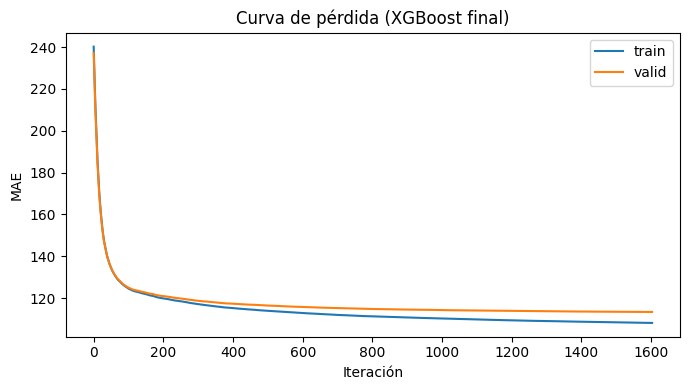

In [12]:
# Graficar curva de entrenamiento (pérdida)
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(evals_result["train"]["mae"])
plt.plot(evals_result["valid"]["mae"])
plt.legend(["train","valid"])
plt.xlabel("Iteración")
plt.ylabel("MAE")
plt.title("Curva de pérdida (XGBoost final)")
plt.tight_layout()
plt.savefig(f"{final_dir}/xgboost_loss_curve_l1.png", dpi=150)
plt.show()
plt.close()

# Persistir el historial para usarlo después sin re-entrenar
import json, os
os.makedirs(final_dir, exist_ok=True)
with open(f"{final_dir}/evals_result.json", "w") as f:
    json.dump(evals_result, f, indent=2)

In [14]:
# Desglose por línea
def group_report(df, y_true, y_pred, by=["LINEA","DIR"]):
    tmp = df.copy()
    tmp["y_true"] = y_true
    tmp["y_pred"] = y_pred
    tmp["abs_err"] = (y_true - y_pred).abs()
    agg = tmp.groupby(by).apply(
        lambda g: pd.Series({
            "MAE": g["abs_err"].mean(),
            "RMSE": (( (g["y_true"]-g["y_pred"])**2 ).mean())**0.5,
            "SLA<=60": (g["abs_err"]<=60).mean(),
            "SLA<=120": (g["abs_err"]<=120).mean(),
            "SLA<=180": (g["abs_err"]<=180).mean(),
            "n": len(g)
        })
    ).reset_index()
    return agg

seg = group_report(test_df, test_df[target_col], y_test_pred, by=["LINEA","DIR"])
print("\n=== TEST por LINEA,DIR ===")
print(seg.sort_values("MAE"))
seg.to_csv(f"{final_dir}/test_segment_metrics.csv", index=False)


=== TEST por LINEA,DIR ===
         LINEA       DIR         MAE        RMSE   SLA<=60  SLA<=120  \
5     Linea_12    VUELTA   40.147835  170.211604  0.853067  0.967911   
7   Linea_13-A       IDA   64.160278  119.344744  0.692532  0.864774   
26     Linea_7    VUELTA   73.025986  179.089576  0.694920  0.864721   
0      Linea_1  CIRCULAR   80.526276  284.949598  0.695269  0.868718   
23     Linea_6    VUELTA   82.378174  226.908055  0.666431  0.838522   
16  Linea_18-B       IDA   84.084213  151.486933  0.601578  0.798777   
8   Linea_13-A    VUELTA   84.485031  217.413021  0.681216  0.829464   
25     Linea_7       IDA  106.231804  317.052231  0.608134  0.817420   
10  Linea_13-B       IDA  118.952194  246.475341  0.561832  0.727481   
19     Linea_2       IDA  128.401123  380.413303  0.498191  0.700543   
22     Linea_6       IDA  136.537659  369.754712  0.556667  0.745177   
11  Linea_13-B    VUELTA  157.098389  317.532675  0.415636  0.606299   
4     Linea_12       IDA  181.397888

C:\Users\Pablo Zamora\AppData\Local\Temp\ipykernel_19200\1611352871.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = tmp.groupby(by).apply(


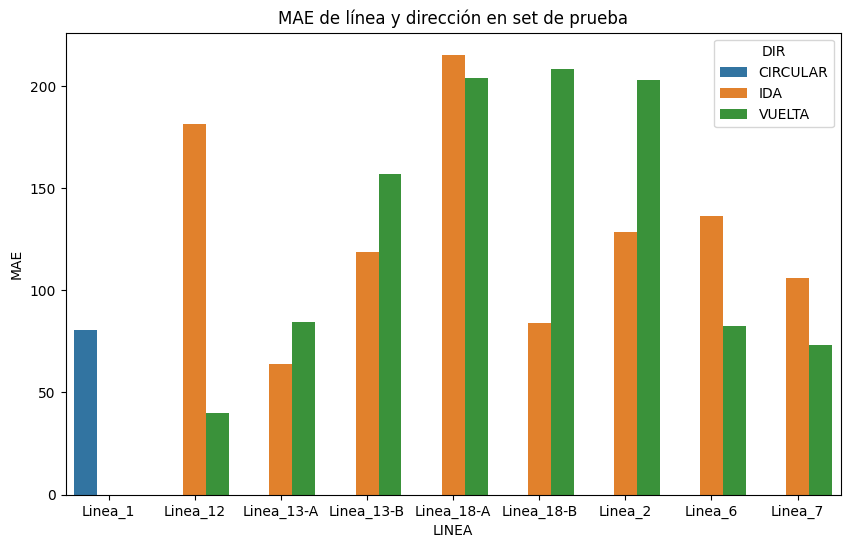

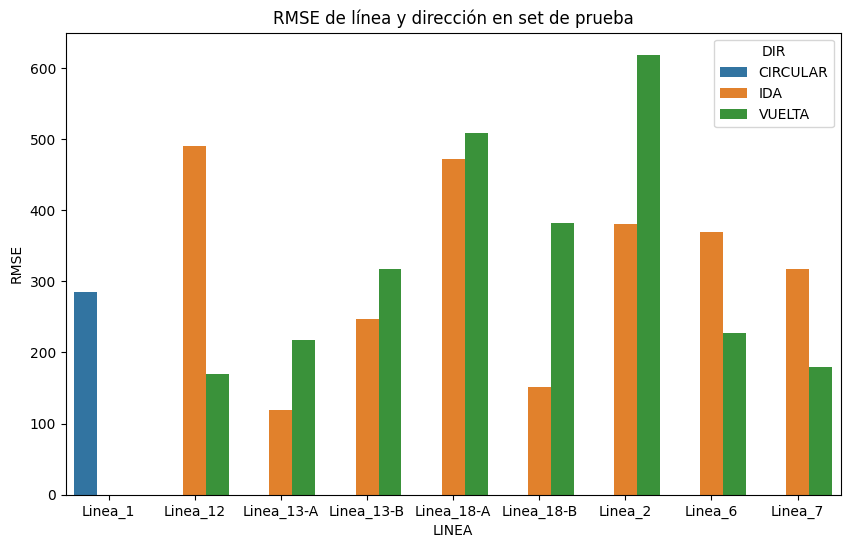

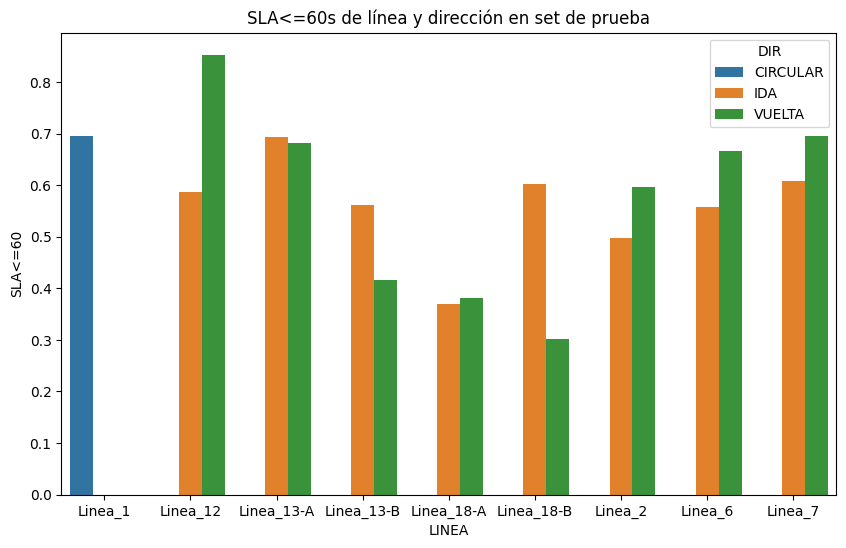

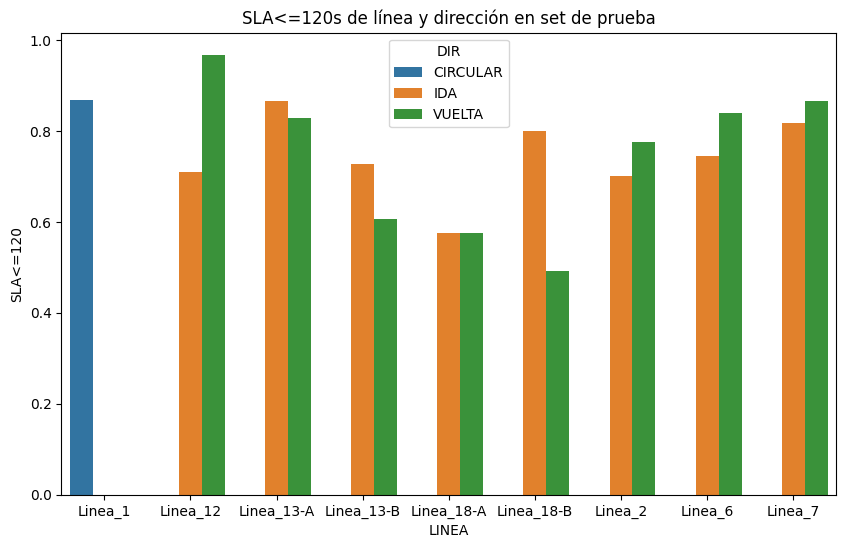

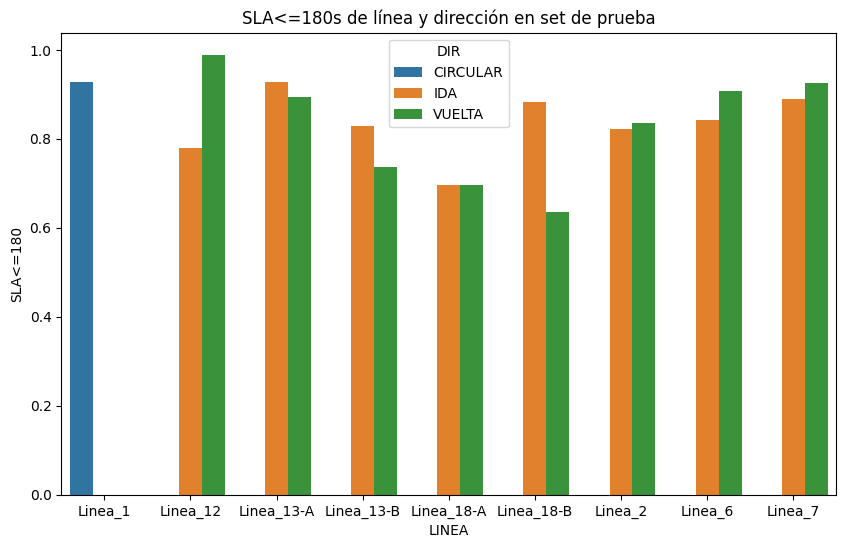

In [15]:
# Graficar desglose por línea
import seaborn as sns
plt.figure(figsize=(10,6))
sns.barplot(data=seg.sort_values("MAE"), x="LINEA", y="MAE", hue="DIR")
plt.title("MAE de línea y dirección en set de prueba")
plt.show()

# Ahora por RMSE
plt.figure(figsize=(10,6))
sns.barplot(data=seg.sort_values("RMSE"), x="LINEA", y="RMSE", hue="DIR")
plt.title("RMSE de línea y dirección en set de prueba")
plt.show()

# Y por SLAs 60, 120, 180 en una misma figura
plt.figure(figsize=(10,6))
sns.barplot(data=seg.sort_values("SLA<=60"), x="LINEA", y="SLA<=60", hue="DIR")

plt.title("SLA<=60s de línea y dirección en set de prueba")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(data=seg.sort_values("SLA<=120"), x="LINEA", y="SLA<=120", hue="DIR")
plt.title("SLA<=120s de línea y dirección en set de prueba")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(data=seg.sort_values("SLA<=180"), x="LINEA", y="SLA<=180", hue="DIR")
plt.title("SLA<=180s de línea y dirección en set de prueba")
plt.show()


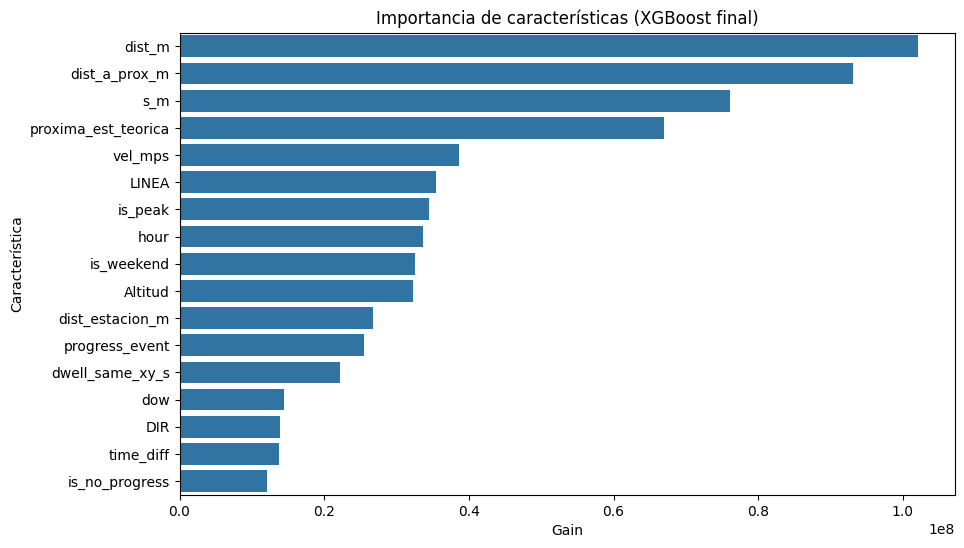

In [21]:
# Graficar importancias finales por gain
fi_gain_final = pd.DataFrame({
    "Característica": feature_cols,
    "Gain": [final_booster.get_score(importance_type="gain").get(f, 0.0) for f in feature_cols]
}).sort_values("Gain", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=fi_gain_final.head(20), x="Gain", y="Característica")
plt.title("Importancia de características (XGBoost final)")
plt.show()